## 初始化

In [1]:

import torch
from model import Model, device
from eeg_dataset import EEG_Dataset
import numpy as np

# 从分类结果获得显著图
dataset = EEG_Dataset(path='C:/Users/14152/Desktop/eegbin/dataset',symmetry=True)
m1 = Model(8, 5,PSD_en=True,PLV_en=False).to(device)
m2 = Model(8, 5,PSD_en=False,PLV_en=True).to(device)
state_dict1 = torch.load('C:/Users/14152/Desktop/eegbin/log/best_dispose_0_PSD_True_PLV_False.pth')
state_dict2 = torch.load('C:/Users/14152/Desktop/eegbin/log/best_dispose_0_PSD_False_PLV_True.pth')
m1.load_state_dict(state_dict1)
m2.load_state_dict(state_dict2)

m1.eval()
m2.eval()


Loaded files: ['co_1_1.npz', 'co_1_2.npz', 'co_3_1.npz', 'co_3_2.npz', 'vs_1_1.npz', 'vs_2_1.npz', 'vs_3_1.npz']
Total entries: 16724
co count: 4103
vs count: 4259


Model(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc_c): Linear(in_features=4096, out_features=16, bias=True)
  (fc1): Linear(in_features=16, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=2, bias=True)
)

## 样本前向计算

合作：[0.6, 0.4]
对抗：[0.4, 0.6]

In [2]:

from tqdm import trange
# 初始化存储显著值的字典
saliency_dict = {i: [] for i in range(2)}  # 假设有5个类别
val_dict =  {i: [] for i in range(2)}
# 遍历整个数据集
for i in trange(len(dataset)):
    (x1, x2), y = dataset[i]
    x1 = x1.unsqueeze(0)
    x2 = x2.unsqueeze(0)
    x1.requires_grad_(), x2.requires_grad_()
    truth = y.argmax().item()

    output1 = m1(x1, x2)
    prediction1 = output1.argmax().item()
    
    
    m1_True = prediction1 == truth

    if m1_True:
        m1.zero_grad()
        output1[0, prediction1].backward()
        saliency_x1 = x1.grad.data.abs().squeeze(0).cpu().detach().numpy()
    
    (x1, x2), y = dataset[i]
    x1 = x1.unsqueeze(0)
    x2 = x2.unsqueeze(0)
    x1.requires_grad_(), x2.requires_grad_()
    output2 = m2(x1, x2)
    prediction2 = output2.argmax().item()
    m2_True = prediction2 == truth
    if m2_True:
        m2.zero_grad()
        output2[0, prediction1].backward()
        saliency_x2 = x2.grad.data.abs().squeeze(0).cpu().detach().numpy()
        
    
    if m1_True and m2_True:
        saliency_dict[truth].append((saliency_x1, saliency_x2))
        val_dict[truth].append((x1.squeeze(0).cpu().detach().numpy(),x2.squeeze(0).cpu().detach().numpy()))

# 计算输入均值

# 计算每个类的平均显著值
avg_saliency_dict = {}
avg_val_dict = {}
for key, saliencies in saliency_dict.items():
    if saliencies:
        avg_saliency_x1 = np.mean([s[0] for s in saliencies], axis=0)
        avg_saliency_x2 = np.mean([s[1] for s in saliencies], axis=0)
        avg_saliency_dict[key] = (avg_saliency_x1, avg_saliency_x2)

for key, vals in val_dict.items():
    if vals:
        avg_x1 = np.mean([v[0] for v in vals], axis=0)
        avg_x2 = np.mean([v[1] for v in vals], axis=0)
        avg_val_dict[key] = (avg_x1,avg_x2)
        



100%|██████████| 16724/16724 [01:27<00:00, 191.49it/s]


## 可视化显著性

saliency of PLV for class 0


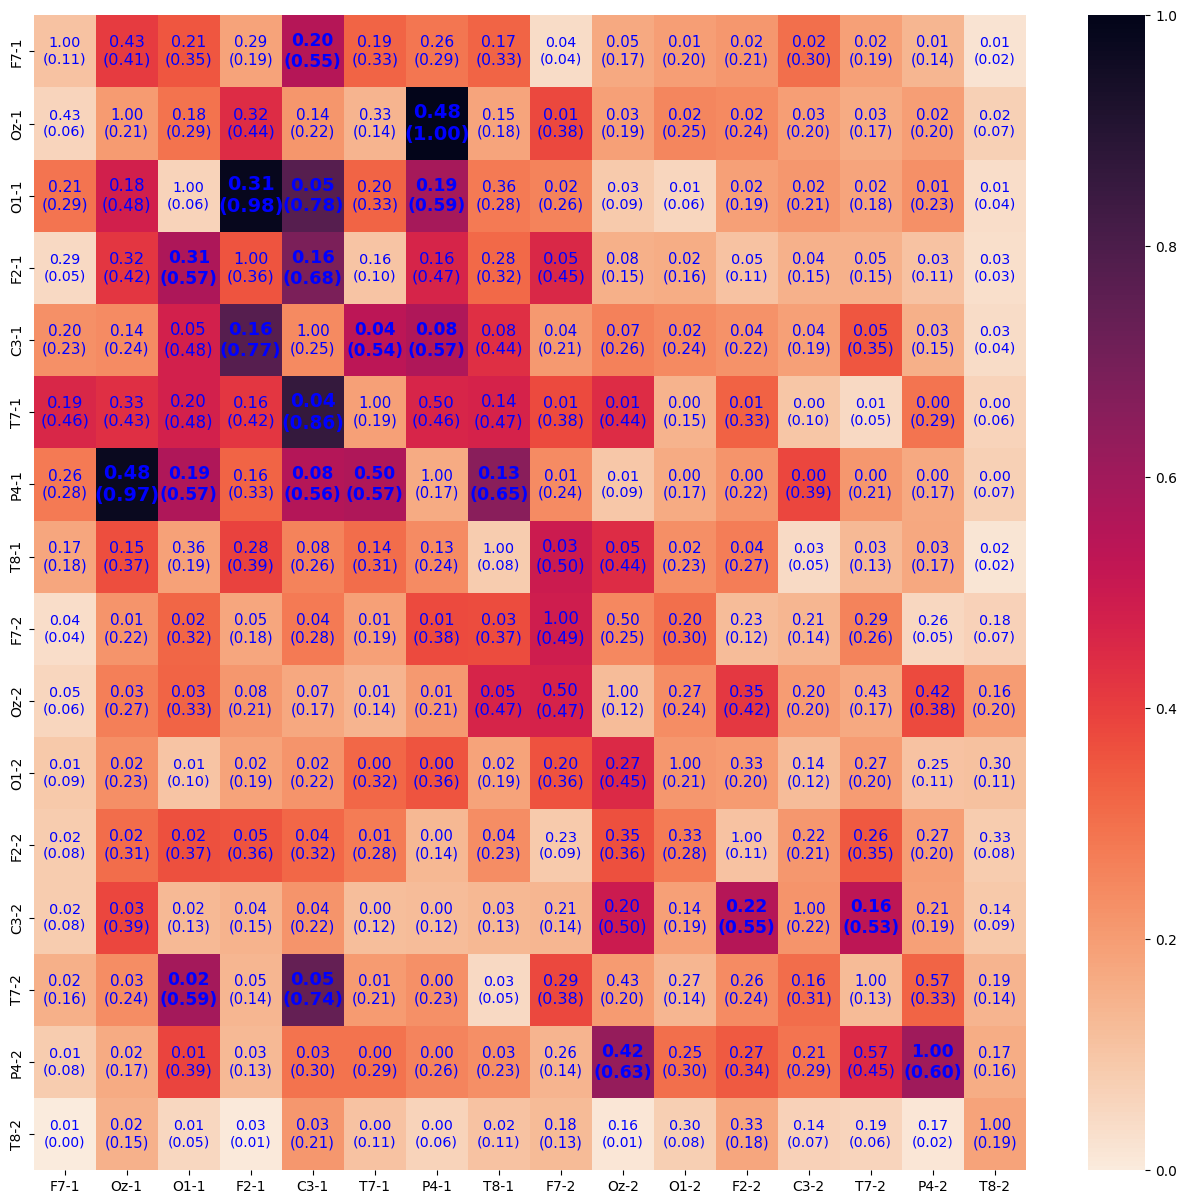

saliency of ENG for class 0


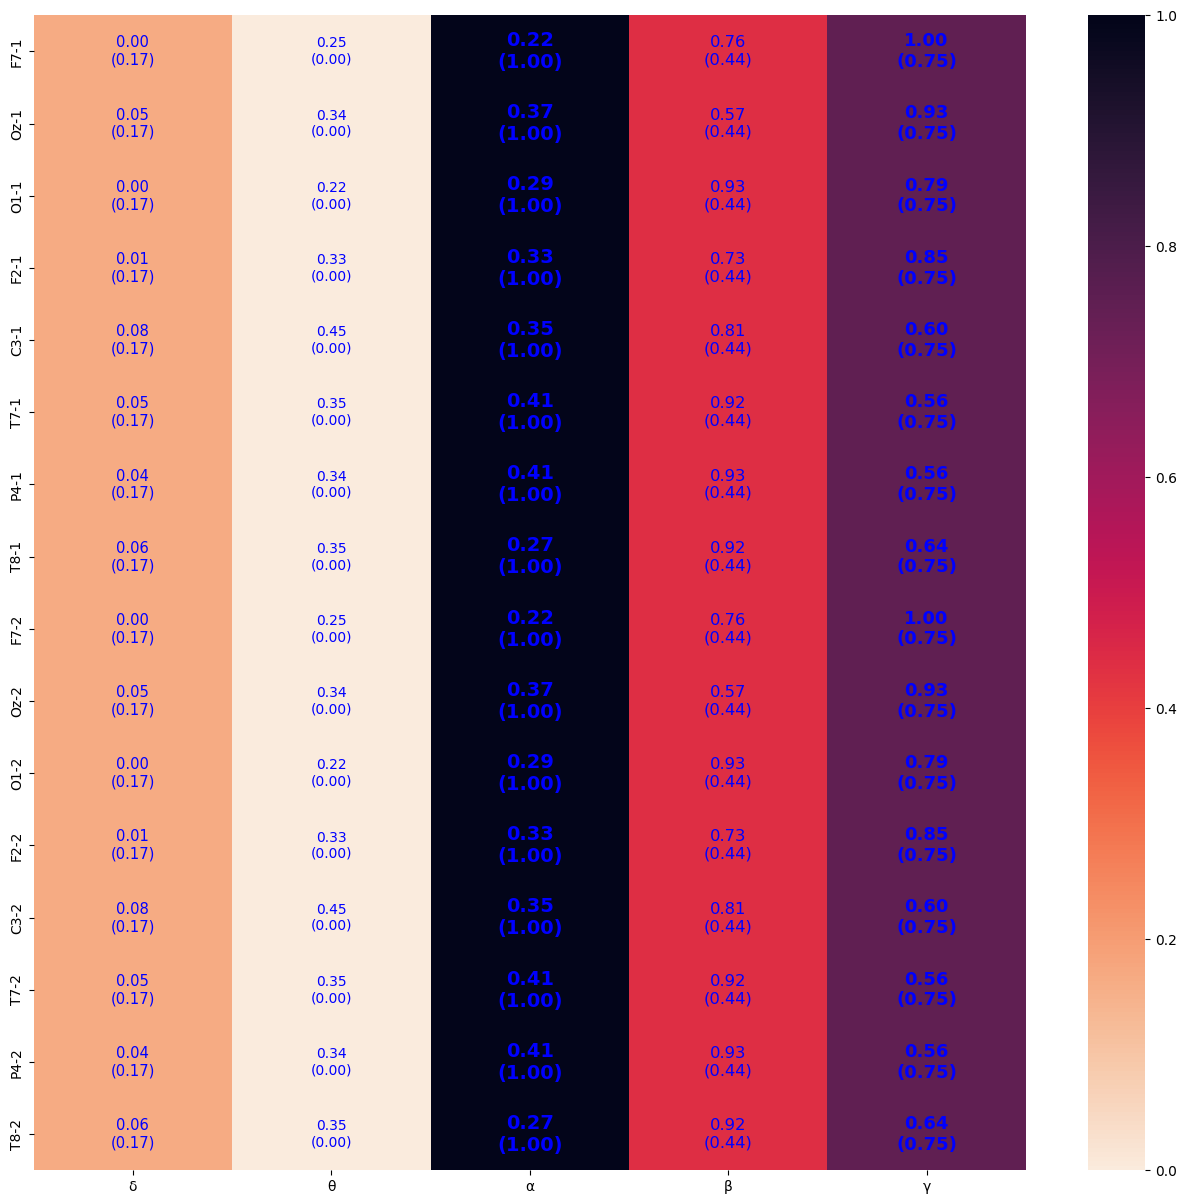

saliency of PLV for class 1


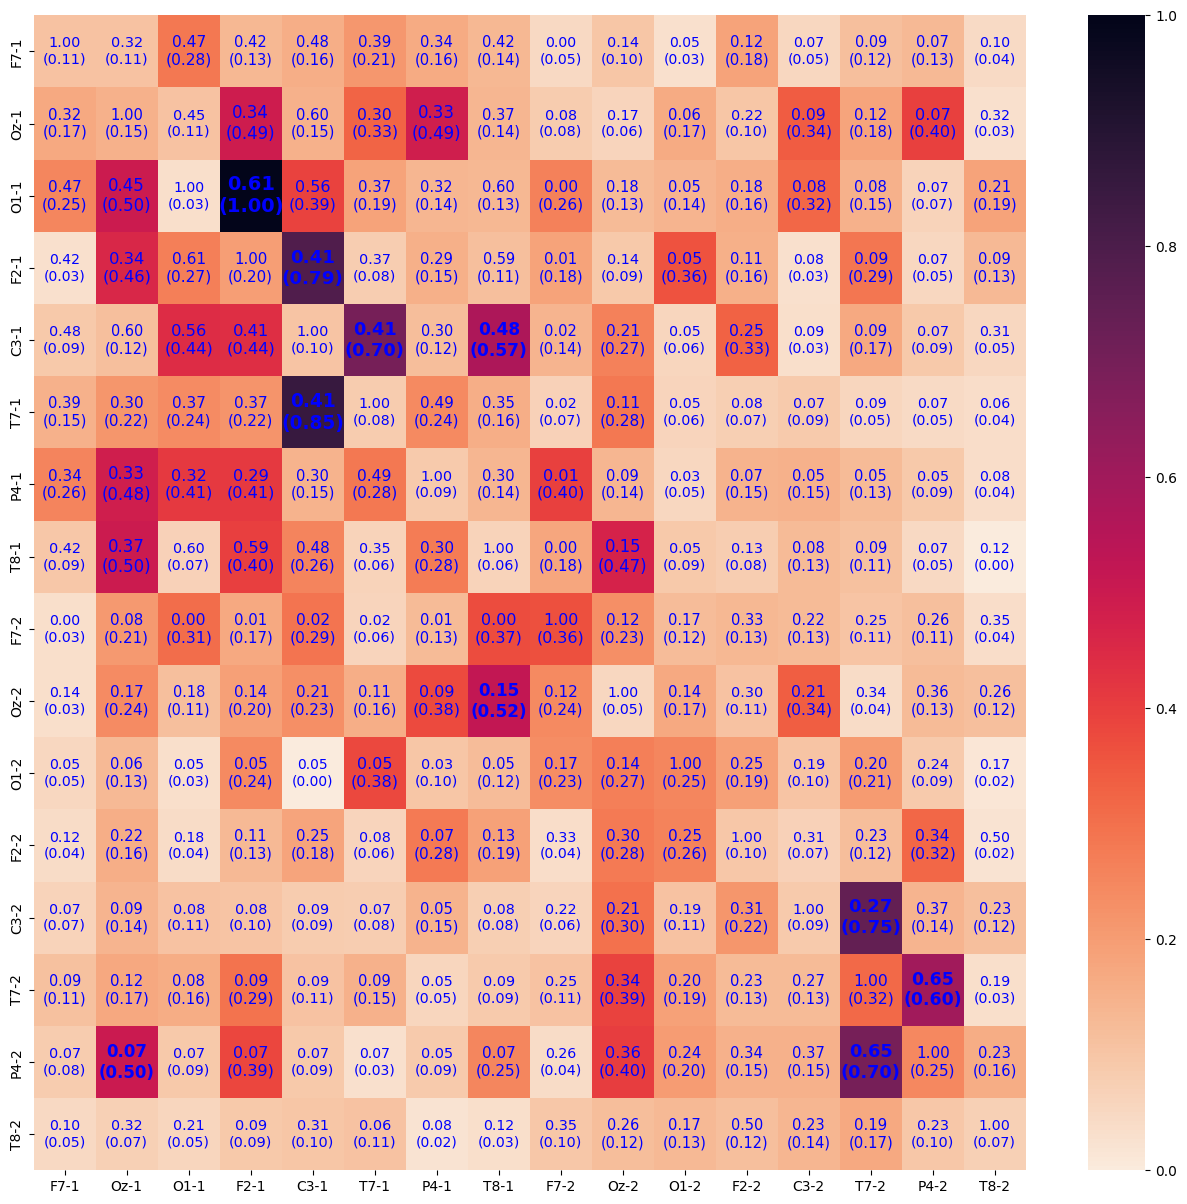

saliency of ENG for class 1


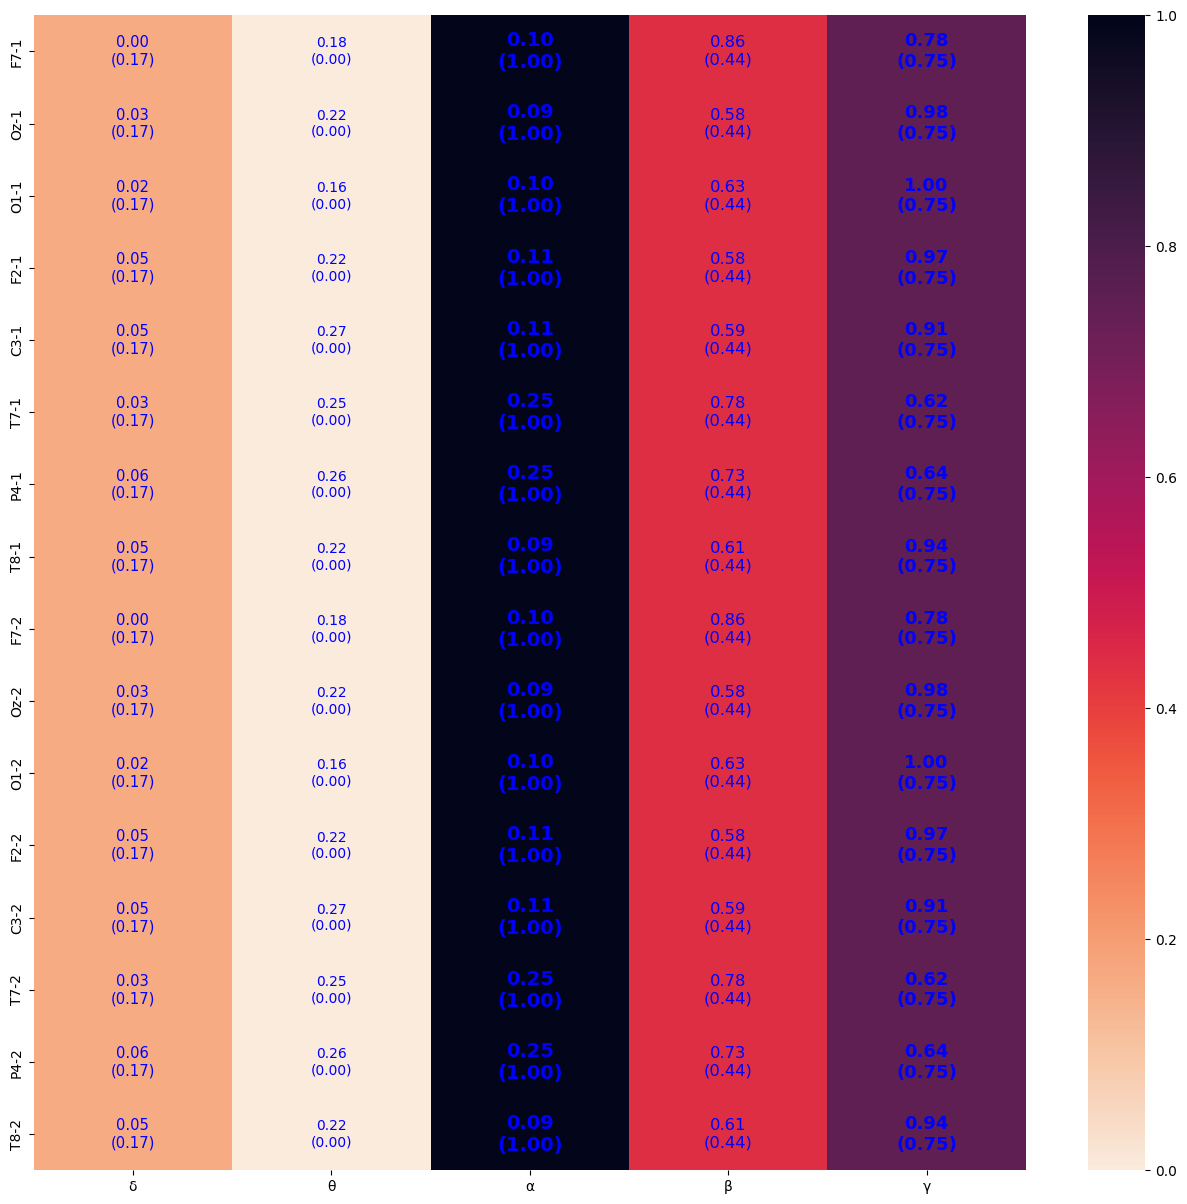

same brain
$C3_1 \leftrightarrow F7_1$ & 0.55 & $0.20\downarrow$ & 0.16 & $0.48\uparrow$ \\
$P4_1 \leftrightarrow Oz_1$ & 1.00 & $0.48\uparrow$ & 0.49 & $0.33\downarrow$ \\
$F2_1 \leftrightarrow O1_1$ & 0.98 & $0.31\downarrow$ & 1.00 & $0.61\uparrow$ \\
$C3_1 \leftrightarrow O1_1$ & 0.78 & $0.05\downarrow$ & 0.44 & $0.56\uparrow$ \\
$P4_1 \leftrightarrow O1_1$ & 0.59 & $0.19\downarrow$ & 0.41 & $0.32\uparrow$ \\
$C3_1 \leftrightarrow F2_1$ & 0.77 & $0.16\downarrow$ & 0.79 & $0.41\uparrow$ \\
$T7_1 \leftrightarrow C3_1$ & 0.86 & $0.04\downarrow$ & 0.85 & $0.41\uparrow$ \\
$P4_1 \leftrightarrow C3_1$ & 0.57 & $0.08\downarrow$ & 0.15 & $0.30\uparrow$ \\
$T7_1 \leftrightarrow P4_1$ & 0.57 & $0.50\uparrow$ & 0.28 & $0.49\downarrow$ \\
$T8_1 \leftrightarrow P4_1$ & 0.65 & $0.13\downarrow$ & 0.28 & $0.30\uparrow$ \\
$F2_2 \leftrightarrow C3_2$ & 0.55 & $0.22\downarrow$ & 0.22 & $0.31\uparrow$ \\
$T7_2 \leftrightarrow C3_2$ & 0.53 & $0.16\downarrow$ & 0.75 & $0.27\uparrow$ \\
$Oz_2 \leftrighta

In [32]:

from matplotlib import pyplot as plt
# from utils.plot_relation_map import plot_weighted_heatmap
import seaborn as sns

plv_cmp = {}


def plot_weighted_heatmap(A, B,xticklabels, yticklabels,cmp = False):
    # Define the figure and axis
    fig, ax = plt.subplots(figsize=(16, 15))

    # Create the heatmap for matrix A
    sns.heatmap(B, annot=False, cmap="rocket_r", cbar=True, ax=ax,xticklabels=xticklabels, yticklabels=yticklabels)

    # Annotate each cell with values from A and B in the format 'val_A(val_B)'
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            value = A[i, j]
            weight = B[i, j]
            size = 10 + (weight * 4)  # Adjust font size based on weight
            if weight > 0.5:
                fontweight = 'bold' 
                if cmp:
                    if (j,i) not in plv_cmp.keys() and (i,j) not in plv_cmp.keys():
                        plv_cmp[(j,i)] = np.ones((4)) * -1
            else:
                fontweight = 'normal'
            ax.text(j + 0.5, i + 0.5, f'{value:.2f}\n({weight:.2f})',color ='blue', ha='center', va='center', fontsize=size,fontweight = fontweight )

    # Adjust the axis
    ax.set_xticks(np.arange(A.shape[1]) + 0.5)
    ax.set_yticks(np.arange(A.shape[0]) + 0.5)
    plt.show()

# 归一化函数
def normalize_matrix(matrix):
    matrix = np.array(matrix)
    min_val = np.min(matrix)
    max_val = np.max(matrix)
    normalized_matrix = (matrix - min_val) / (max_val - min_val)
    return normalized_matrix

coords_ch = ['F7-1', 'Oz-1', 'O1-1', 'F2-1', 'C3-1', 'T7-1', 'P4-1', 'T8-1', 'F7-2', 'Oz-2', 'O1-2', 'F2-2', 'C3-2', 'T7-2', 'P4-2', 'T8-2']
coords_band = ['δ', 'θ', 'α', 'β', 'γ']

normalized_x2s = []
normalized_saliency_x2s = []
normalized_x1s = []
normalized_saliency_x1s = []

# 对每种y的平均显著值进行可视化
for key, (avg_saliency_x1, avg_saliency_x2) in avg_saliency_dict.items():
    normalized_saliency_x1 = normalize_matrix(avg_saliency_x1)
    normalized_saliency_x1s.append(normalized_saliency_x1)
    normalized_saliency_x2 = normalize_matrix(avg_saliency_x2)
    normalized_saliency_x2s.append(normalized_saliency_x2)
    normalized_x1 = normalize_matrix(avg_val_dict[key][0])
    normalized_x1s.append(normalized_x1)
    normalized_x2 = normalize_matrix(avg_val_dict[key][1])
    normalized_x2s.append(normalized_x2)

    
    
    print(f'saliency of PLV for class {key}')
    plot_weighted_heatmap(normalized_x2,normalized_saliency_x2, coords_ch, coords_ch,True)
    
    print(f'saliency of ENG for class {key}')
    plot_weighted_heatmap(normalized_x1,normalized_saliency_x1, coords_band, coords_ch)

for k in plv_cmp.keys():
    j,i = k
    plv_cmp[k][0] = max(normalized_saliency_x2s[0][j,i],normalized_saliency_x2s[0][i,j])
    plv_cmp[k][1] = normalized_x2s[0][j,i]
    plv_cmp[k][2] = max(normalized_saliency_x2s[1][j,i],normalized_saliency_x2s[1][i,j])
    plv_cmp[k][3] = normalized_x2s[1][j,i]

# 输出比较值
print("same brain")
ch_connections = {}
vis_same_brain = []

for k,v in plv_cmp.items():
    j,i = k
    arr1,arr2 = ('\\uparrow','\\downarrow') if v[1] > v[3] else('\\downarrow','\\uparrow')
    if i == j:
        continue
    if coords_ch[j][-1:] == coords_ch[i][-1:]:
        ch1 = coords_ch[j][:2]
        ch2 = coords_ch[i][:2]
        if (ch1,ch2) not in ch_connections.keys() and (ch2,ch1) not in ch_connections.keys():
            vis_same_brain.append((ch1,ch2,v[0],v[1],v[2],v[3]))
            ch_connections[(ch1,ch2)] = 1
            ch_connections[(ch2,ch1)] = -1
        print(f"${coords_ch[j].replace('-','_')} \\leftrightarrow {coords_ch[i].replace('-','_')}$ & {v[0]:.2f} & ${v[1]:.2f}{arr1}$ & {v[2]:.2f} & ${v[3]:.2f}{arr2}$ \\\\")

print("cross brain")
ch_connections = {}
vis_cross_brain = []
for k,v in plv_cmp.items():
    j,i = k
    if i == j:
        continue
    arr1,arr2 = ('\\uparrow','\\downarrow') if v[1] > v[3] else('\\downarrow','\\uparrow')
    if coords_ch[j][-1:] != coords_ch[i][-1:]:
        ch1 = coords_ch[j][:2]
        sbj1 = coords_ch[j][-1:]
        ch2 = coords_ch[i][:2]
        sbj2 = coords_ch[i][-1:]
        if sbj1 == sbj2: # 是单脑，避免自环
            if (ch1,ch2) not in ch_connections.keys() and (ch2,ch1) not in ch_connections.keys():
                vis_cross_brain.append((ch1,ch2,v[0],v[1],v[2],v[3]))
                ch_connections[(ch1,ch2)] = 1
                ch_connections[(ch2,ch1)] = -1
        else:
            vis_cross_brain.append((ch1,ch2,v[0],v[1],v[2],v[3]))
            ch_connections[(ch1,ch2)] = 1
            ch_connections[(ch2,ch1)] = -1
        
        print(f"${coords_ch[j].replace('-','_')} \\leftrightarrow {coords_ch[i].replace('-','_')}$ & {v[0]:.2f} & ${v[1]:.2f}{arr1}$ & {v[2]:.2f} & ${v[3]:.2f}{arr2}$ \\\\")

## 可视化PLV结果

single brain
cross brain


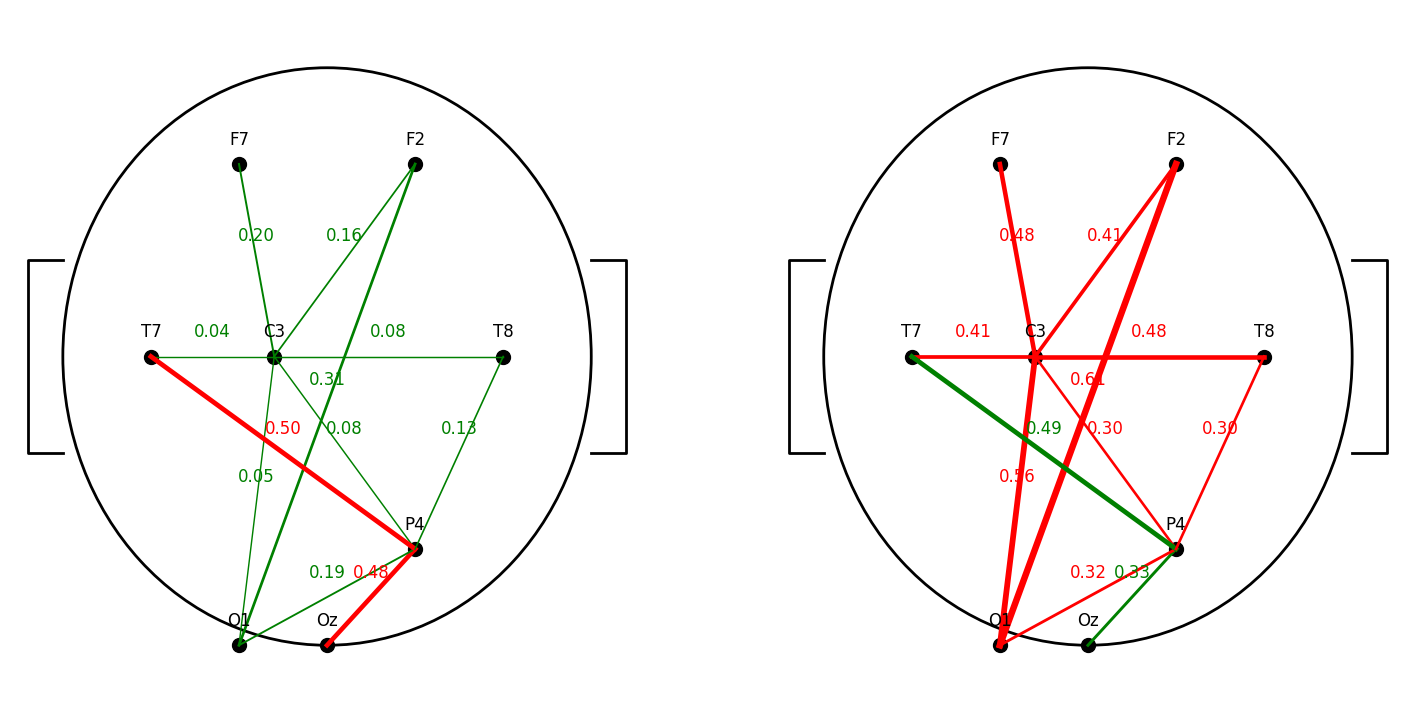

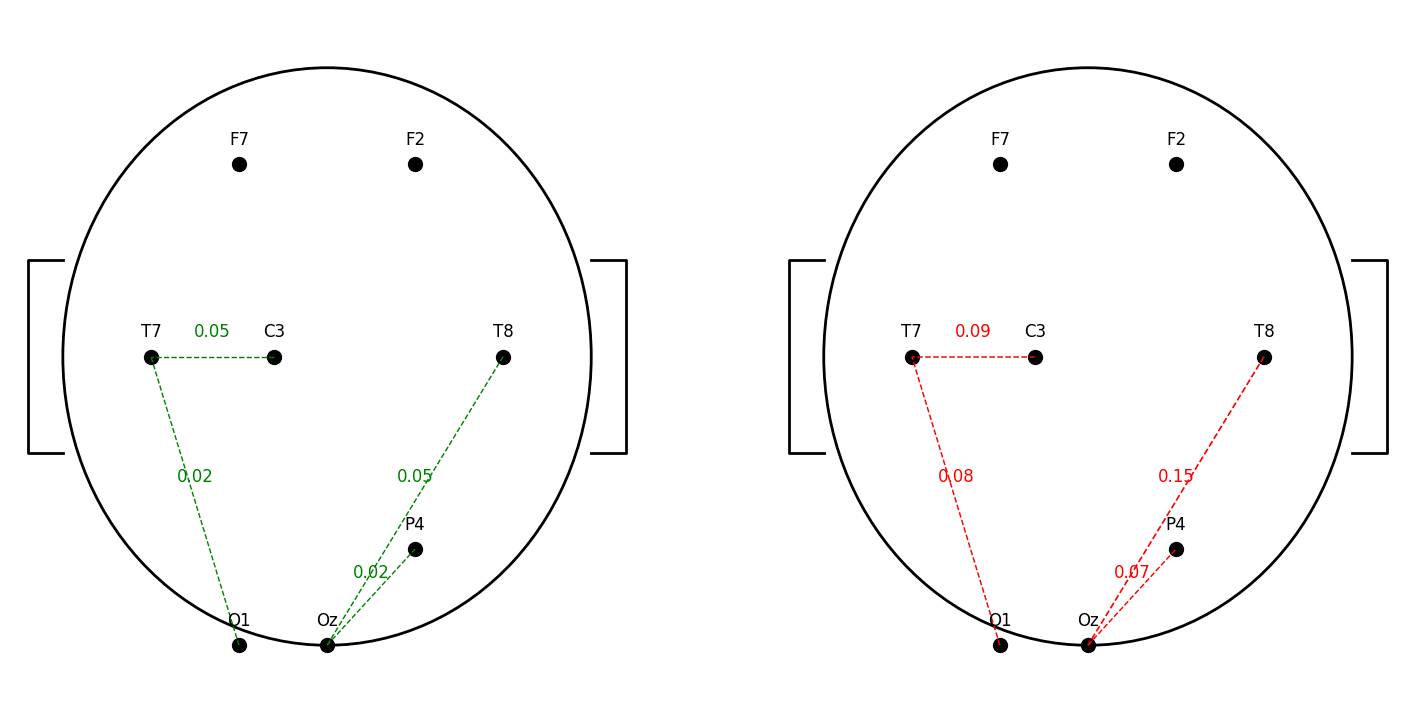

In [29]:
electrode_positions = {
    'C3': [-0.3, 0],
    'F7': [-0.5, 1],
    'P4': [0.5, -1],
    'Oz': [0, -1.5],
    'F2': [0.5, 1],
    'O1': [-0.5, -1.5],
    'T7': [-1, 0],
    'T8': [1, 0]
}

def plot_connections(ax, connections,linestyle=None):
    for (elec1, elec2, signif_coop, strength_coop, signif_comp, strength_comp) in connections:
        pos1 = electrode_positions[elec1]
        pos2 = electrode_positions[elec2]
        
        color1 = 'red' if strength_coop>strength_comp else 'green'
        color2 = 'red' if strength_coop<strength_comp else 'green'
        lw1 = (strength_coop * 10) ** 2 /10 + 1 # 根据显著值调整线条粗细
        lw2 = (strength_comp * 10) ** 2  /10 + 1
        ax[0].plot([pos1[0], pos2[0]], [pos1[1], pos2[1]], color=color1, lw=lw1,linestyle = linestyle) 
        ax[0].text((pos1[0] + pos2[0])/2, (pos1[1] + pos2[1])/2+0.1,f'{strength_coop:.2f}' ,color=color1, fontsize=12, ha='center')
        ax[1].plot([pos1[0], pos2[0]], [pos1[1], pos2[1]], color=color2, lw=lw2,linestyle = linestyle)
        ax[1].text((pos1[0] + pos2[0])/2, (pos1[1] + pos2[1])/2+0.1,f'{strength_comp:.2f}' ,color=color2, fontsize=12, ha='center')
        

def plot_head_outline(ax):
    circle = plt.Circle((0, 0), 1.5, color='black', fill=False, lw=2)
    ax.add_artist(circle)
    ears = np.array([[-1.5, 0.5], [-1.7, 0.5], [-1.7, -0.5], [-1.5, -0.5], 
                     [1.5, 0.5], [1.7, 0.5], [1.7, -0.5], [1.5, -0.5]])
    ax.plot(ears[:4, 0], ears[:4, 1], color='black', lw=2)
    ax.plot(ears[4:, 0], ears[4:, 1], color='black', lw=2)

# 单脑
print("single brain")
fig, ax = plt.subplots(1,2,figsize=(18, 9))
ax[0].axis('off')
ax[0].set_xlim(-1.8,1.8)
ax[0].set_ylim(-1.8,1.8)
ax[1].axis('off')
ax[1].set_xlim(-1.8,1.8)
ax[1].set_ylim(-1.8,1.8)
for name, pos in electrode_positions.items():
    ax[0].scatter(pos[0], pos[1], s=100, c='black')
    ax[0].text(pos[0], pos[1]+0.1, name, fontsize=12, ha='center')
    ax[1].scatter(pos[0], pos[1], s=100, c='black')
    ax[1].text(pos[0], pos[1]+0.1, name, fontsize=12, ha='center')
plot_connections(ax, vis_same_brain)
plot_head_outline(ax[0])
plot_head_outline(ax[1])

# 跨脑
print("cross brain")
fig, ax = plt.subplots(1,2,figsize=(18, 9))
ax[0].axis('off')
ax[0].set_xlim(-1.8,1.8)
ax[0].set_ylim(-1.8,1.8)
ax[1].axis('off')
ax[1].set_xlim(-1.8,1.8)
ax[1].set_ylim(-1.8,1.8)
for name, pos in electrode_positions.items():
    ax[0].scatter(pos[0], pos[1], s=100, c='black')
    ax[0].text(pos[0], pos[1]+0.1, name, fontsize=12, ha='center')
    ax[1].scatter(pos[0], pos[1], s=100, c='black')
    ax[1].text(pos[0], pos[1]+0.1, name, fontsize=12, ha='center')
plot_connections(ax, vis_cross_brain,linestyle='--')
plot_head_outline(ax[0])
plot_head_outline(ax[1])

# 脑地形图

## 可视化PSD结果

2
(8, 3)


TypeError: plot_topomap() got an unexpected keyword argument 'vmin'

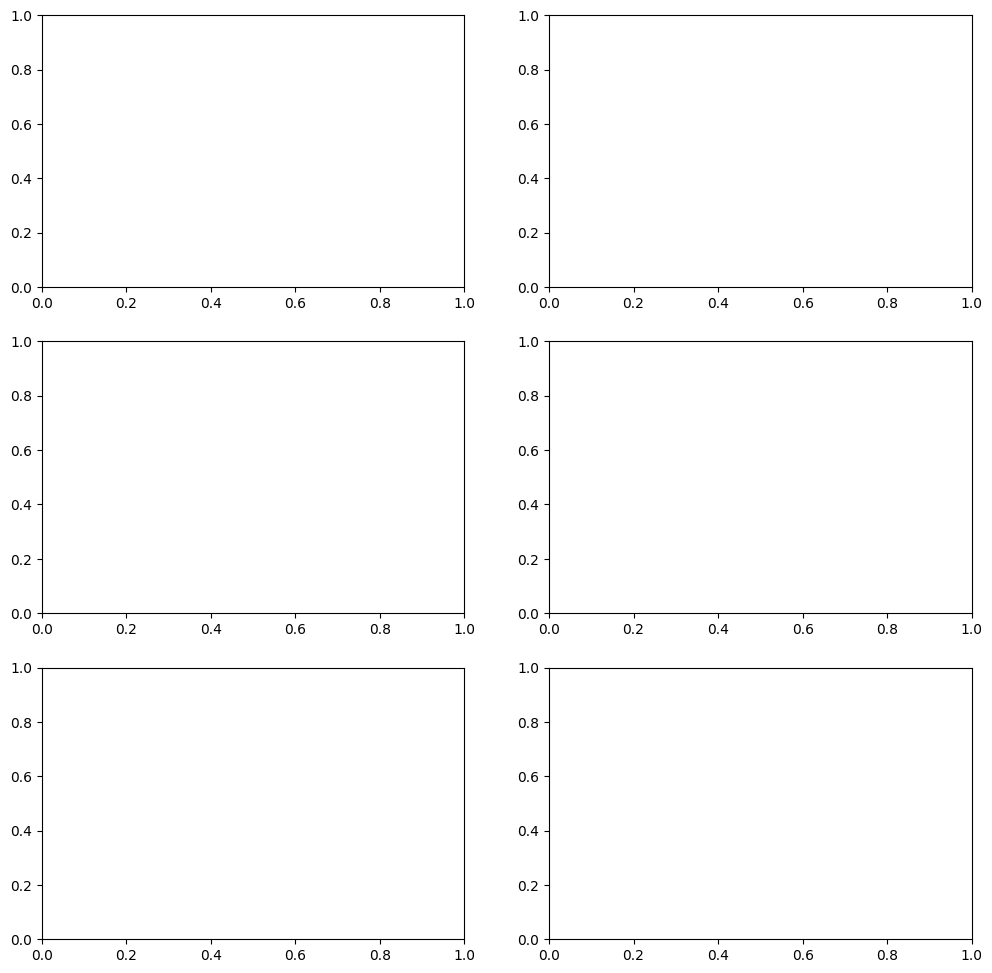

In [53]:
import mne

print(len(normalized_x1s)) # len为2，有两个类别0和1

print(normalized_x1s[0][:8,-3:].shape) # 这是你需要可视化的数据，shape为(8, 3)，8是导联数，3是频谱数
# 频谱分别为
bands = ['α', 'β', 'γ']
# 通道分别为标准10-20导联
channels = ['F7', 'Oz', 'O1', 'F2', 'C3', 'T7', 'P4', 'T8']
# 创建一个只包含指定通道的montage
montage = mne.channels.make_standard_montage('standard_1020')
selected_pos = {ch: montage.dig[montage.ch_names.index(ch) + 3]['r'] for ch in channels}

custom_montage = mne.channels.make_dig_montage(ch_pos=selected_pos, coord_frame='head')

# 创建一个3行2列的图
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

# 遍历频段和类别绘制脑地形图
for i, band in enumerate(bands):
    for j in range(2):
        # 提取数据，这里假设数据形状为 (导联数, 频谱数)
        power_data = normalized_x1s[j][:8, i]
        
        # 创建虚拟的info对象
        info = mne.create_info(ch_names=channels, sfreq=250, ch_types='eeg')
        
        # 生成一个恒定功率的虚拟信号
        signal_data = np.tile(power_data, (250, 1)).T  # 生成一个250个样本点的恒定信号
        
        evoked = mne.EvokedArray(signal_data, info)
        evoked.set_montage(custom_montage)
        
        # 绘制脑地形图
        im, _ = mne.viz.plot_topomap(
            evoked.data.mean(axis=1), evoked.info, axes=axes[i, j], show=False, cmap='rocket_r',
            sensors='k.', names=channels, mask=np.ones(len(channels), dtype=bool),
            mask_params=dict(marker='o', markersize=20, markerfacecolor='w', markeredgecolor='k')
        )
        axes[i, j].set_title(f'{bands[i]} band - {"co" if j == 0 else "vs"}')
        fig.colorbar(im, ax=axes[i, j])

# 调整布局
plt.tight_layout()
plt.show()